### Exercise 12
Model real-world time series.<br>
• Train time series DL models.<br>
• Make data stationary and retrain models.<br>
• Compare with statistical and ML time series models.<br>

In [2]:
#all imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from utils import stationarity_tests


In [3]:
#load BTC data
def load_btc(start="2016-01-01", end=None) -> pd.DataFrame:
    df = yf.download(
        "BTC-USD",
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )

    if df.empty:
        raise RuntimeError("No data returned from yfinance.")

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns = [c.lower() for c in df.columns]

    #ensure a proper datetime index
    df = df.reset_index()
    if "date" not in df.columns:
        df = df.rename(columns={df.columns[0]: "date"})

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")

    # only relevant columns
    df = df[["close", "volume"]].copy()

    df = df.asfreq("D")
    df["close"] = df["close"].interpolate(limit_direction="both")
    df["volume"] = df["volume"].fillna(0.0)

    return df


In [4]:
# Create windowed dataset for DL models
def make_windows(df_feat: pd.DataFrame, y: pd.Series, lookback=60, h=1):
    X_list, Y_list, idx_list = [], [], []

    values = df_feat.values.astype(np.float32)
    yv = y.values.astype(np.float32)
    index = df_feat.index

    for t in range(lookback - 1, len(df_feat) - h):
        x_win = values[t - lookback + 1 : t + 1]
        y_win = yv[t + 1 : t + 1 + h]  # next steps
        X_list.append(x_win)
        Y_list.append(y_win if h > 1 else y_win[0])
        idx_list.append(index[t + h])  # timestamp of last predicted step

    X = np.stack(X_list)
    Y = np.stack(Y_list)
    idx = pd.DatetimeIndex(idx_list)
    return X, Y, idx


                   close       volume
date                                 
2025-12-13  90298.710938  64237748110
2025-12-14  88175.179688  50465972205
2025-12-15  86419.781250  45559514323
2025-12-16  87843.984375  41262178223
2025-12-17  85822.335938  40467881984
Date range: 2016-01-01 → 2025-12-17


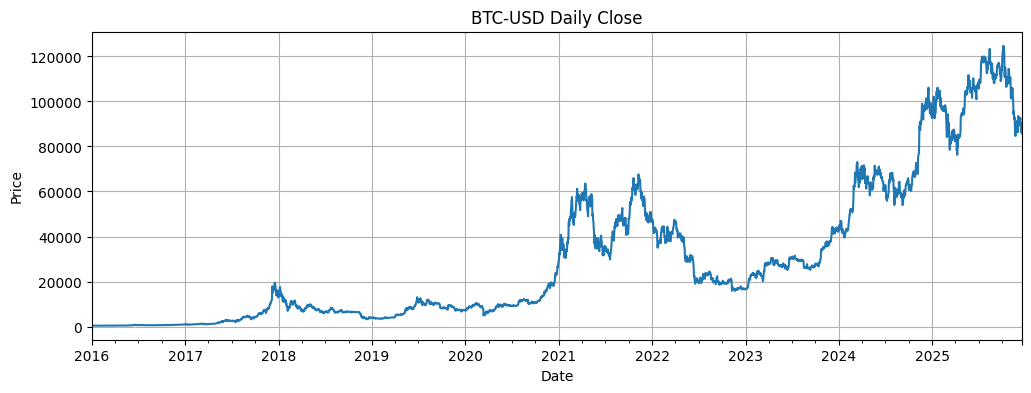

In [5]:
df = load_btc(start="2016-01-01")

print(df.tail())
print("Date range:", df.index.min().date(), "→", df.index.max().date())

plt.figure(figsize=(12, 4))
df["close"].plot()
plt.title("BTC-USD Daily Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


Model Real-world TS